# Предсказание коэффициента восстановления золота из золотосодержащей руды

In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
from sklearn.dummy import  DummyRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import StratifiedKFold
import optuna
from sklearn.metrics import make_scorer

# 1. Подготовка данных

## 1.1. Первое знакомство с данными

In [2]:
path10 = 'gold_recovery_full_new.csv'
path11 = 'gold_recovery_test_new.csv'
path12 = 'gold_recovery_train_new.csv'

path20 = '/datasets/gold_recovery_full_new.csv'
path21 = '/datasets/gold_recovery_test_new.csv'
path22 = '/datasets/gold_recovery_train_new.csv'

if os.path.exists(path10):
    df_full = pd.read_csv(path10)
    df_test = pd.read_csv(path11)
    df_train = pd.read_csv(path12)
elif os.path.exists(path20):
    df_full = pd.read_csv(path20)
    df_test = pd.read_csv(path21)
    df_train = pd.read_csv(path22)
else:
    print('файлы не найдены')

In [3]:
display(df_full.head())
print(df_full.info())

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                19439 non-null  object 
 1   final.output.concentrate_ag                         19438 non-null  float64
 2   final.output.concentrate_pb                         19438 non-null  float64
 3   final.output.concentrate_sol                        19228 non-null  float64
 4   final.output.concentrate_au                         19439 non-null  float64
 5   final.output.recovery                               19439 non-null  float64
 6   final.output.tail_ag                                19438 non-null  float64
 7   final.output.tail_pb                                19338 non-null  float64
 8   final.output.tail_sol                               19433 non-null  float64


In [4]:
display(df_test.head())
print(df_test.info())

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,...,12.033091,-498.350935,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987
4,2016-09-01 04:59:59,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,...,12.025367,-500.786497,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5290 entries, 0 to 5289
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5290 non-null   object 
 1   primary_cleaner.input.sulfate               5286 non-null   float64
 2   primary_cleaner.input.depressant            5285 non-null   float64
 3   primary_cleaner.input.feed_size             5290 non-null   float64
 4   primary_cleaner.input.xanthate              5286 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5290 non-null   float64
 10  primary_clea

In [5]:
display(df_train.head())
print(df_train.info())

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14149 non-null  object 
 1   final.output.concentrate_ag                         14148 non-null  float64
 2   final.output.concentrate_pb                         14148 non-null  float64
 3   final.output.concentrate_sol                        13938 non-null  float64
 4   final.output.concentrate_au                         14149 non-null  float64
 5   final.output.recovery                               14149 non-null  float64
 6   final.output.tail_ag                                14149 non-null  float64
 7   final.output.tail_pb                                14049 non-null  float64
 8   final.output.tail_sol                               14144 non-null  float64


**Вывод:**
- df_full и df_train содержат по 86 столбцов, а df_test - 52. Придется из df_train убирать "лишние" столбцы
- В данных есть пропуски - придется заполнять
- тип данных в основном float64, кроме параметра date, тип которого object - необходимо заметить тип и сделаем его индексом

## 1.2. Проверка корректности расчета эффективности обогащения

Исходя из предоставленного описания:
C — доля золота в концентрате после флотации/очистки;
F — доля золота в сырье/концентрате до флотации/очистки;
T — доля золота в отвальных хвостах после флотации/очистки.
можно предположить, что с параметрами датасета это свзяно следующим образом:
С = rougher.output.concentrate_au
F = rougher.input.feed_au
T = rougher.output.tail_au

In [6]:
# Подготовим функцию для расчета
def recovery_calculator(row):
    c = row['rougher.output.concentrate_au']
    f = row['rougher.input.feed_au']
    t = row['rougher.output.tail_au']
    result = (c * (f - t))/(f * (c - t))*100
    return result

In [7]:
# Выполним расчет
df_train['calculated_rougher.output.recovery'] = df_train.apply(recovery_calculator, axis=1)
# и оценим полученный рузльтат визуально
df_train[['calculated_rougher.output.recovery','rougher.output.recovery']].head()

,calculated_rougher.output.recovery,rougher.output.recovery
0,87.107763,87.107763
1,86.843261,86.843261
2,86.842308,86.842308
3,87.226430,87.226430
4,86.688794,86.688794


На первый взгляд один в один. Но посчитаем через MAE

In [8]:
mae = mean_absolute_error(df_train['rougher.output.recovery'], df_train['calculated_rougher.output.recovery'])
print('MAE = ', mae)

MAE =  9.682896147825551e-15


Как видно, результат очень точный!

Удалим столбец с расчитанным значением 'rougher.output.recovery' за ненадобностью

In [9]:
df_train = df_train.drop(columns='calculated_rougher.output.recovery')

## 1.3. Признаки, недоступные в тестовой выборке

In [10]:
train_params = df_train.columns
test_params = df_test.columns
diff_train_test_params = sorted(list(set(train_params) - set(test_params) ))
print('количество столбцов в тренировочной выборке = ', len(train_params))
print('количество столбцов в тестовой выборке = ', len(test_params))
print('список признаков, недоступных в тествой выборке:\n', diff_train_test_params)

количество столбцов в тренировочной выборке =  87
количество столбцов в тестовой выборке =  53
список признаков, недоступных в тествой выборке:
 ['final.output.concentrate_ag', 'final.output.concentrate_au', 'final.output.concentrate_pb', 'final.output.concentrate_sol', 'final.output.recovery', 'final.output.tail_ag', 'final.output.tail_au', 'final.output.tail_pb', 'final.output.tail_sol', 'primary_cleaner.output.concentrate_ag', 'primary_cleaner.output.concentrate_au', 'primary_cleaner.output.concentrate_pb', 'primary_cleaner.output.concentrate_sol', 'primary_cleaner.output.tail_ag', 'primary_cleaner.output.tail_au', 'primary_cleaner.output.tail_pb', 'primary_cleaner.output.tail_sol', 'rougher.calculation.au_pb_ratio', 'rougher.calculation.floatbank10_sulfate_to_au_feed', 'rougher.calculation.floatbank11_sulfate_to_au_feed', 'rougher.calculation.sulfate_to_au_concentrate', 'rougher.output.concentrate_ag', 'rougher.output.concentrate_au', 'rougher.output.concentrate_pb', 'rougher.outpu

Недоступны:
1. оба целевых признака (`final.output.recovery`, `final.output.recovery`)
2. расчётные характеристики параметров сырья (`rougher.calculation...`)
3. параметры продукта флотации (`rougher.output.concentrate_..`)
5. параметры продукта первичной очистки (`primary_cleaner.output.concentrate_..`)
6. параметры продукта вторичной очистки (`final.output.concentrate_..`)
12. отвальные хвосты флотации (`rougher.output.tail_..`)
13. отвальные хвосты первичной очистки (`primary_cleaner.output.tail_...`)
14. отвальные хвосты вторичной очистки (`secondary_cleaner.output.tail_`)
15. отвальные хвосты финальные (общие) (`final.output.tail_..`)

иными словами в тестовой выборке отсутствуют
1. параметры продукта после каждой стадии
2. отвальные хвосты после каждой стадии, в т.ч. общие
3. расчетные харакетристики сырья
4. целевые параметры процесса

а присутствуют:
1. все входные пармстры для флотации и первичной очистки (`input`)
2. параметры состояния на каждом этапе (`state`)

вывод:
1. необходимо в тестовую выборку добавить оба целевых признака

## 1.4. Предобработка данных

Заменим тип даты на соответствующий и установим даты в качестве индекса

In [11]:
# изменим тип
df_full['date'] = pd.to_datetime(df_full['date'], format='%Y-%m-%d %H:%M:%S')
df_test['date'] = pd.to_datetime(df_test['date'], format='%Y-%m-%d %H:%M:%S')
df_train['date'] = pd.to_datetime(df_train['date'], format='%Y-%m-%d %H:%M:%S')

# сделаем индексом
df_full.set_index('date', inplace=True)
df_test.set_index('date', inplace=True)
df_train.set_index('date', inplace=True)

### 1.4.1. Заполнение пропусков

In [12]:
print('в выборках присутствуют короткие промежутки отсуствующих значений')
display(df_full.loc[( ('2017-12-17 05:00:00' < df_full.index) & (df_full.index < '2017-12-17 15:00:00')), 'rougher.input.feed_sol'])

print('так же присутствуют средне долгие промежутки отсуствующих значений')
display(df_full.loc[(('2017-12-16 02:00:00' < df_full.index) & (df_full.index < '2017-12-17 12:00:00') ), 'rougher.input.floatbank11_xanthate'])

print('и совсем длинные периоды')
display(df_full.loc[( ('2017-02-27 17:59:59' < df_full.index) & (df_full.index < '2017-03-12 10:59:59')), 'rougher.input.floatbank11_xanthate'])

в выборках присутствуют короткие промежутки отсуствующих значений


date
2017-12-17 05:59:59    27.448429
2017-12-17 06:59:59    25.267509
2017-12-17 07:59:59    26.176558
2017-12-17 08:59:59    21.214718
2017-12-17 09:59:59          NaN
2017-12-17 10:59:59          NaN
2017-12-17 11:59:59    32.263823
2017-12-17 12:59:59    35.105592
2017-12-17 13:59:59    37.677373
2017-12-17 14:59:59    38.550045
Name: rougher.input.feed_sol, dtype: float64

так же присутствуют средне долгие промежутки отсуствующих значений


date
2017-12-16 02:59:59    7.202016
2017-12-16 03:59:59    7.194959
2017-12-16 04:59:59    7.007955
2017-12-16 05:59:59    3.558781
2017-12-16 23:59:59         NaN
2017-12-17 00:59:59         NaN
2017-12-17 01:59:59         NaN
2017-12-17 02:59:59         NaN
2017-12-17 03:59:59         NaN
2017-12-17 04:59:59         NaN
2017-12-17 05:59:59         NaN
2017-12-17 06:59:59         NaN
2017-12-17 07:59:59         NaN
2017-12-17 08:59:59    2.045122
2017-12-17 09:59:59    4.619273
2017-12-17 10:59:59    5.514070
2017-12-17 11:59:59    5.323963
Name: rougher.input.floatbank11_xanthate, dtype: float64

и совсем длинные периоды


date
2017-02-27 18:59:59    4.044859
2017-02-27 19:59:59    3.410875
2017-02-28 14:59:59         NaN
2017-02-28 15:59:59         NaN
2017-02-28 16:59:59         NaN
                         ...   
2017-03-12 05:59:59         NaN
2017-03-12 06:59:59    0.023120
2017-03-12 07:59:59         NaN
2017-03-12 08:59:59         NaN
2017-03-12 09:59:59         NaN
Name: rougher.input.floatbank11_xanthate, Length: 276, dtype: float64

Можно заметить, что значения в предыдущих и последующих записях отличаются незначительно. Поэтому для заполненжия пропусков применим заполенение средним по n значениям. С учетом того, что встречаются разрывы различной продолжительности будем заполнеять средним по возрастанию. Напишем для этого функцию.


In [13]:
def empty_values_replacer(df, empty_values_range=10):
    """
    Данная функция заполняет пропуски средним окна из n значений. Размер окна перебирается итеративно по возрастанию.
    """
    col_list = df.columns
    for i in range(2, empty_values_range):
        for col in col_list:
            try:
                df.loc[df[col].isna(), col] = df[col].rolling(f'{i}h').mean()[df[df[col].isna()].index].copy()
            except Exception as e:
                print(f'column = {col}, exception = {e}')
    return df

In [14]:
df_full = empty_values_replacer(df_full, 25)

Оценим изменения

In [15]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19439 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         19439 non-null  float64
 1   final.output.concentrate_pb                         19439 non-null  float64
 2   final.output.concentrate_sol                        19429 non-null  float64
 3   final.output.concentrate_au                         19439 non-null  float64
 4   final.output.recovery                               19439 non-null  float64
 5   final.output.tail_ag                                19439 non-null  float64
 6   final.output.tail_pb                                19439 non-null  float64
 7   final.output.tail_sol                               19439 non-null  float64
 8   final.output.tail_au                     

Как видно, пропуски уменьшились, но все еще присутствуют. Покаоставим их.

Заполним пропуски в тестовой выбоке. Но сперва убедимся что тестовая вобрка (df_test) является частью исходных данных (df_full)

In [16]:
# объединим тестовую и полную выборку чтобы сравнить значения
df_full_train_joined =  df_full.join(df_train, lsuffix='_full', rsuffix='_train')

In [17]:
print('в тренировочной выборке нет соответсвющих полной выборке записей в количестве ', len(df_full_train_joined.loc[df_full_train_joined['rougher.output.recovery_train'].isna(),['rougher.output.recovery_full', 'rougher.output.recovery_train']]),'шт.')
print('при этом')
print('в полной вборке выборке "не хватает" ', len(df_full_train_joined.loc[df_full_train_joined['rougher.output.recovery_full'].isna(),['rougher.output.recovery_full', 'rougher.output.recovery_train']]),'записей')
print('при этом')
print('для непустых записей из тренировочной выборки не совпадает' , len(df_full_train_joined.loc[(~df_full_train_joined['rougher.output.recovery_train'].isna() &
                                                                                                   (df_full_train_joined['rougher.output.recovery_full']!=df_full_train_joined['rougher.output.recovery_train']))
,['rougher.output.recovery_full', 'rougher.output.recovery_train']]), 'записей')
print('и это')
display(df_full_train_joined.loc[(~df_full_train_joined['rougher.output.recovery_train'].isna() &
                                  (df_full_train_joined['rougher.output.recovery_full']!=df_full_train_joined['rougher.output.recovery_train']))
,['rougher.output.recovery_full', 'rougher.output.recovery_train']]  )
print('что по сути одно и тоже, и разница, видимо, в долях')

в тренировочной выборке нет соответсвющих полной выборке записей в количестве  5290 шт.
при этом
в полной вборке выборке "не хватает"  0 записей
при этом
для непустых записей из тренировочной выборки не совпадает 2 записей
и это


,rougher.output.recovery_full,rougher.output.recovery_train
date,,
2018-06-29 10:59:59,37.792299,37.792299
2018-07-17 15:59:59,91.924340,91.924340


что по сути одно и тоже, и разница, видимо, в долях


как видно из п. 1.1.
в df_full - 19439 записи
в df_train - 14149 записи

проверим сперва епоявидись ли после объединения пустые записи относящиеся к тренировочной и к тестовой выборкам

Получается, полная выбока перекрывает собой тренировочную и тестовую выбоки. А, поскольку, пропуски (хоть и частично) в df_full мы уже заполнили, затянем их в тестовую выборку. Подготовим для этого функцию.

In [18]:
def value_replacer(df1, df2):
    """
    данная функция по каждоиму столбцу датафрейма df1 заполняет в нем пропуски значениями из df2.
    если пропуски в обоих - заполняет пропусками
    """
    col_list = df1.columns
    for col in col_list:
        try:
            df1.loc[df1[col].isna(), col] = df2.loc[df1[col].isna().index,col]
        except Exception as e:
            print(e)
    return df1

In [19]:
df_test = value_replacer(df_test, df_full)
df_train = value_replacer(df_train, df_full)

In [20]:
display(df_train.info())
display(df_test.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 14149 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         14149 non-null  float64
 1   final.output.concentrate_pb                         14149 non-null  float64
 2   final.output.concentrate_sol                        14139 non-null  float64
 3   final.output.concentrate_au                         14149 non-null  float64
 4   final.output.recovery                               14149 non-null  float64
 5   final.output.tail_ag                                14149 non-null  float64
 6   final.output.tail_pb                                14149 non-null  float64
 7   final.output.tail_sol                               14149 non-null  float64
 8   final.output.tail_au                     

None

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5290 entries, 2016-09-01 00:59:59 to 2017-12-31 23:59:59
Data columns (total 52 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   primary_cleaner.input.sulfate               5290 non-null   float64
 1   primary_cleaner.input.depressant            5289 non-null   float64
 2   primary_cleaner.input.feed_size             5290 non-null   float64
 3   primary_cleaner.input.xanthate              5290 non-null   float64
 4   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 5   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 6   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 8   primary_cleaner.state.floatbank8_c_air      5290 non-null   float64
 9   primary_cleaner.state.floatbank8_c_level    5290 

None

Как видно, от пропусков в тестовом датасете избавились, а вот в тренировочном они еще остались. Удалим строки с пропусками из тренировочного датасета.

In [21]:
df_train = df_train.dropna()
df_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13714 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         13714 non-null  float64
 1   final.output.concentrate_pb                         13714 non-null  float64
 2   final.output.concentrate_sol                        13714 non-null  float64
 3   final.output.concentrate_au                         13714 non-null  float64
 4   final.output.recovery                               13714 non-null  float64
 5   final.output.tail_ag                                13714 non-null  float64
 6   final.output.tail_pb                                13714 non-null  float64
 7   final.output.tail_sol                               13714 non-null  float64
 8   final.output.tail_au                     

Было 14149 записей, стало - 13897. 152 записи удалено. На фоне 14 тыс это порядка 1%. Уменьшение незначительное.

**Подытог:** в тренировочной и тестовой выборках от пропусков избавислись.

### 1.4.2. Анализ данных

#### 1.4.2.1. Изменение концентрации на различных этапах очистки

#### 1.4.2.1.1. Среднее значение

Посмотрим на среднее значение концентарций на каждо этапе

In [22]:
phase_en = ['rougher.output.','primary_cleaner.output.','final.output.']
phase_ru = ['флотация', 'первичная очистка', 'финальные характеристики']
phase_en_ru = list(zip(phase_en, phase_ru))
concentrates = [ 'concentrate_au', 'concentrate_ag', 'concentrate_pb', 'concentrate_sol']
titles =  ['Aurum', 'Argentum', 'Plumbum', 'Sol' ]

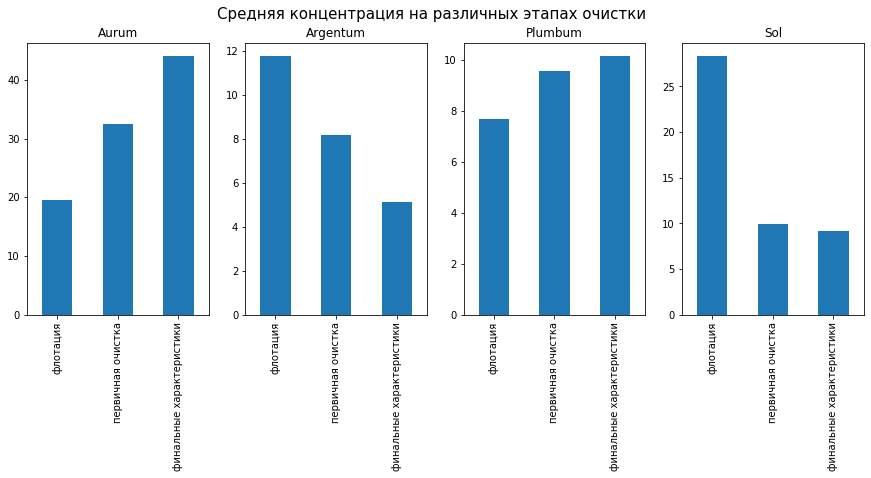

In [23]:
def barplot_concentration_printer(phase:list, concentrates:list,  titles:list, suptitle:str):
    """
    Функция отображает горизонтальные графики типа barplot для заданного элемента на трех стадиях очистки
    """
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(15,5))
    fig.suptitle(suptitle, fontsize = 15)
    for concentrate, title, ax in zip(concentrates, titles, axes.ravel()):
        df_train[[phase[0][0] + concentrate, phase_en_ru[1][0] + concentrate, phase_en_ru[2][0] + concentrate]]\
            .rename(columns={phase_en_ru[0][0]  + concentrate:phase_en_ru[0][1],phase_en_ru[1][0]  + concentrate:phase_en_ru[1][1],phase_en_ru[2][0]  + concentrate:phase_en_ru[2][1]}).mean().plot(kind='bar', ax=ax, title = title)
    plt.show()

barplot_concentration_printer(phase_en_ru, concentrates, titles, 'Средняя концентрация на различных этапах очистки')

Среднее значение повторяет медианное (что очевидно, поскольку распрпделения тяготеют к нормальной форме) и дополнительной информации при анализе изменений не дают.

**Выводы:**
по итогу:
1. Концентрация золота возрастает более чем в 2 раза
2. Концентрация серебра падает более чем в 2 раза
3. Концентрация свинца так незначительно растет (примерно на четверть)
4. (опциональный пункт) Концентрация (солей?) падает примерно в 3 раза.

#### 1.4.2.1.2. Ящик с усами

Изучим распределения через диаграмму "ящик сусами". Возможно появятся подбробонсти

In [24]:
def boxplot_concentration_printer(df:pd.DataFrame, phase:list, concentrate:str,  title:str):
    """
    Функция отображает вертикальные графики типа boxplot для заданного элемента на трех стадиях очистки
    """
    fig, axes = plt.subplots(nrows=len(phase), ncols=1, figsize=(14,5))
    fig.suptitle(title, fontsize = 15)
    for i , ax in zip(phase, axes.ravel()):
        df.rename(columns={str(i[0]+concentrate):str(i[1])}).boxplot(column=[str(i[1])], vert=False, ax=ax)
    plt.show()

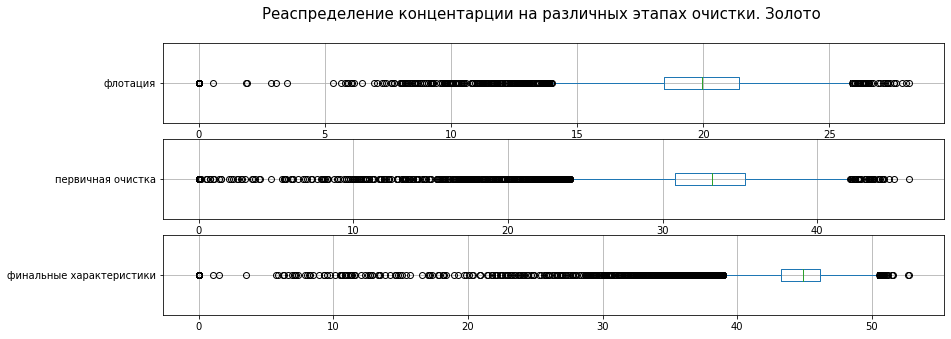

In [25]:
boxplot_concentration_printer(df_train, phase_en_ru, 'concentrate_au', 'Реаспределение концентарции на различных этапах очистки. Золото')

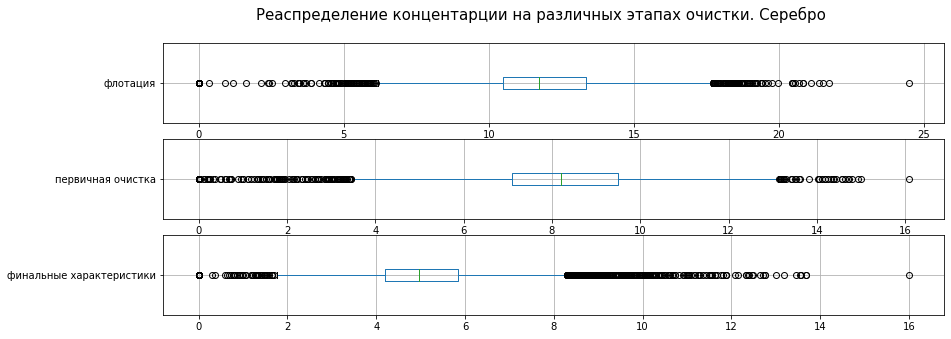

In [26]:
boxplot_concentration_printer(df_train, phase_en_ru, 'concentrate_ag', 'Реаспределение концентарции на различных этапах очистки. Серебро')

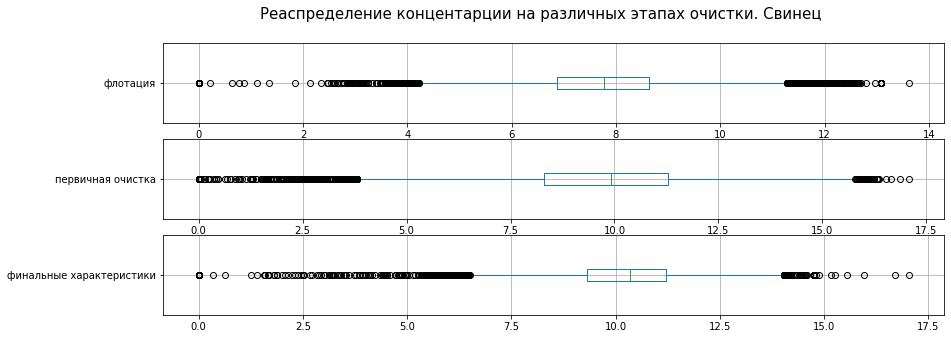

In [27]:
boxplot_concentration_printer(df_train, phase_en_ru, 'concentrate_pb', 'Реаспределение концентарции на различных этапах очистки. Свинец')

**Выводы:**

1. Концентрация золота возрастает
2. Концентрация серебра падает
3. Концентрация свинца так незначительно растет
4. распрпделения носят нормальный характер без ярко-выраженных скосов с примерно симметричным количеством выбросов, как следствие медианное значение близко к ранее найденному среднему

тем не менее выбросы диапазон выбросов сверху распрпделения становится все короче, а снизу - все длиннее. Выглядит как-будто концентрация достигает своего максимума.

#### 1.4.2.2. Распределение размеров гранул сырья на обучающей и тестовой выборках

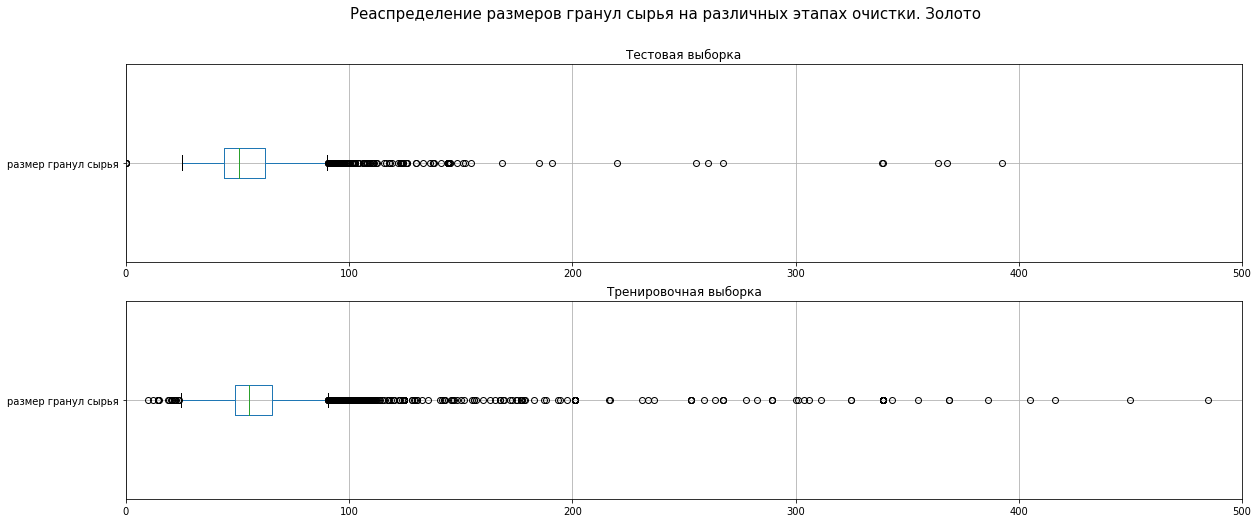

In [28]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20,8))
fig.suptitle('Реаспределение размеров гранул сырья на различных этапах очистки. Золото', fontsize = 15)

df_test.rename(columns={'rougher.input.feed_size':'размер гранул сырья'}).boxplot(column=['размер гранул сырья'], vert=False, ax=axes[0])
df_train.rename(columns={'rougher.input.feed_size':'размер гранул сырья'}).boxplot(column=['размер гранул сырья'], vert=False, ax=axes[1])
axes[0].set_xlim(0, 500)
axes[1].set_xlim(0, 500)
axes[0].title.set_text('Тестовая выборка')
axes[1].title.set_text('Тренировочная выборка')

Или, тоже самое, но в виде гистограммы

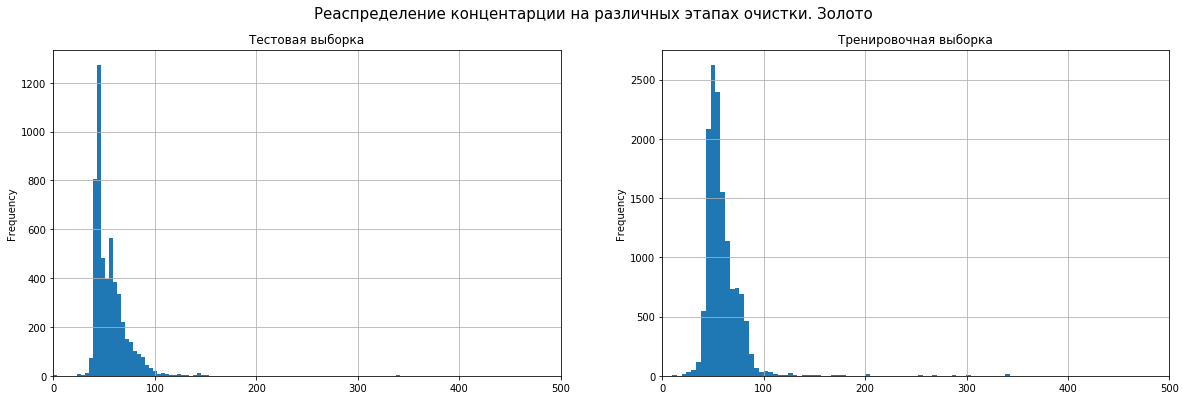

In [29]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,6))
fig.suptitle('Реаспределение концентарции на различных этапах очистки. Золото', fontsize = 15)

df_test['rougher.input.feed_size'].rename('размер гранул сырья').plot(kind = 'hist', ax=axes[0], bins = 100, grid=True)
df_train['rougher.input.feed_size'].rename('размер гранул сырья').plot(kind = 'hist', ax=axes[1], bins = 100, grid=True)
axes[0].set_xlim(0, 500)
axes[1].set_xlim(0, 500)
axes[0].title.set_text('Тестовая выборка')
axes[1].title.set_text('Тренировочная выборка')

На гистограмме так же заметно что:
1. Тестовая выборка имеет более явное смещение вправо, в то время как тренировочная выглядит более нормально
2. Медианное значение так же на гистограме больше на тренировочной выборке чем на тестовой

In [30]:
print('Средний размер гранул сырья на тренировочной выборке =', df_train['rougher.input.feed_size'].mean())
print('Средний размер гранул сырья на тестовой выборке =', df_test['rougher.input.feed_size'].mean())
print('Относительная разница в размере сосатвляет', round((df_train['rougher.input.feed_size'].mean()-df_test['rougher.input.feed_size'].mean())/df_train['rougher.input.feed_size'].mean()*100, 2), '%')

Средний размер гранул сырья на тренировочной выборке = 59.66896895895133
Средний размер гранул сырья на тестовой выборке = 55.95275402889511
Относительная разница в размере сосатвляет 6.23 %


Примем это как есть, ничего делать с этим не будем..

#### 1.4.2.3. Суммарная концентрация всех веществ на разных стадиях: (сырье, черновой и финальный концентраты)

In [31]:
def concentrate_printer_4elem(df, descs, concs, phases):
    for desc, phase in zip(descs, phases) :
        print(desc, round(df[[phase + concs[0], phase + concs[1], phase + concs[2], phase + concs[3]]].sum().sum(), 2))

def concentrate_printer_3elem(df, descs, concs, phases):
    for desc, phase in zip(descs, phases) :
        print(desc, round(df[[phase + concs[0], phase + concs[1], phase + concs[2]]].sum().sum(), 2))

In [32]:
descriptions = ['суммарная концентрация веществ на стадии флотации =', 'суммарная концентрация веществ на стадии первичной очистки =', 'суммарная концентрация веществ финального продукта =']
concentrates_4elem = [ 'concentrate_au', 'concentrate_ag', 'concentrate_pb', 'concentrate_sol']
concentrates_3elem = [ 'concentrate_au', 'concentrate_ag', 'concentrate_pb']

##### 1.4.2.3.1 С выбросами

In [33]:
print('c учетом солей')
concentrate_printer_4elem(df_train, descriptions, concentrates_4elem, phase_en)
print()
print('без учета солей')
concentrate_printer_3elem(df_train, descriptions, concentrates_3elem, phase_en)

c учетом солей
суммарная концентрация веществ на стадии флотации = 922311.91
суммарная концентрация веществ на стадии первичной очистки = 824672.12
суммарная концентрация веществ финального продукта = 939032.37

без учета солей
суммарная концентрация веществ на стадии флотации = 533863.82
суммарная концентрация веществ на стадии первичной очистки = 687845.91
суммарная концентрация веществ финального продукта = 813784.95


##### 1.4.2.3.1 Без выбросов

In [34]:
def outliers_cutter(df, phases, concs, koef=1.5):
    """
    Данная функция для каждого значения концентрации на каждой из стадий делает срез по диапазону Q1-1.5*IQR - Q3+1.5*IQR
    """
    df = df.copy()
    for phase in phases:
        for conc in concs:

            Q1 = df[phase + conc].quantile(0.25)
            Q3 = df[phase + conc].quantile(0.75)
            IQR = Q3 - Q1
            df = df[(df[phase + conc] > Q1-koef*IQR ) & (df[phase + conc] < Q3+koef*IQR)]

    return df

In [35]:
df_train_cuted = outliers_cutter(df_train, phase_en, concentrates)

In [36]:
concentrate_printer_4elem(df_train_cuted, descriptions, concentrates_4elem, phase_en)
print()
concentrate_printer_3elem(df_train_cuted, descriptions, concentrates_3elem, phase_en)

суммарная концентрация веществ на стадии флотации = 691200.81
суммарная концентрация веществ на стадии первичной очистки = 614247.23
суммарная концентрация веществ финального продукта = 689620.0

суммарная концентрация веществ на стадии флотации = 397851.25
суммарная концентрация веществ на стадии первичной очистки = 514000.26
суммарная концентрация веществ финального продукта = 598564.08


Разница прям, существенная! Оценим изменения на графиках

Оценим распрпделение без выбросов на примере концентрации Золота. (Было)

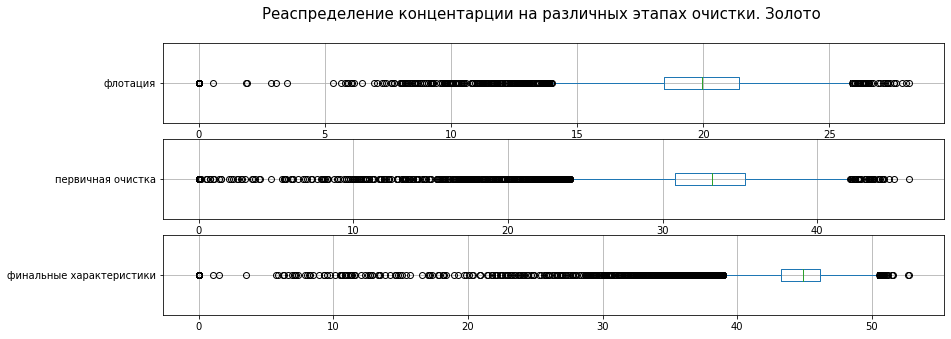

In [37]:
boxplot_concentration_printer(df_train, phase_en_ru, 'concentrate_au', 'Реаспределение концентарции на различных этапах очистки. Золото')

Стало

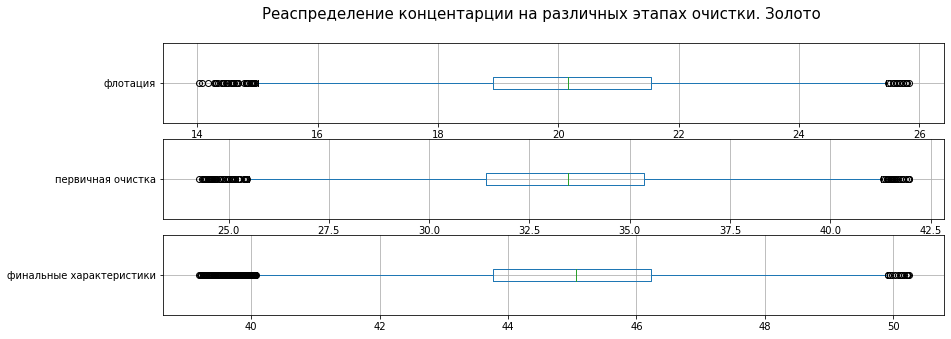

In [38]:
boxplot_concentration_printer(df_train_cuted, phase_en_ru, 'concentrate_au', 'Реаспределение концентарции на различных этапах очистки. Золото')

Длинные хвосты выбросов стали заметно короче. Стрижка прошла удачно =)

**Выводы:**
1. Не учитывая соли (?) видно, что суммарная концентрация металлов выросла примерно на 60%
2. Учитывая соли (?) видно, что суммарная концентрация на этапе первичной очистки проседает, затем приходит в прежнее состояние. (вероятно за счет повышения концентрации металлов)
3. По рассчитанным значениям средней концентрациям на разлиных стадиях видно что концентрация Золота вырастает примерно в два раза
4. Очистка выборки от выбросов существенно изменяет значения концентрации в т.ч.и суммарные

~"штош",  видимо имеет смысл очистить тренировочную выборку от выбросов и обучать модель уже без них~

In [39]:
# сохраним изначальную версию тренировочной выборки в df_train_init
df_train_init = df_train.copy()
# и отфильтруем записи с выбросоми
df_train = outliers_cutter(df_train, phase_en, concentrates, koef=1.5)

In [40]:
params_to_cut = []
for p in phase_en:
    for c in concentrates:
        params_to_cut.append(p+c)
print('пересечение между множеством столбцов тестовой выборки и параметров на "стрижку выбросов" составляет:', set(params_to_cut) & set(df_test.columns))
print('т.е. пересекающихся значений' )
print('(просто иллюстрация для проверки) а вот для множеств 1,2,3 и 3,4,5 общим является:', set([1,2,3]) & set([3,4,5]))

пересечение между множеством столбцов тестовой выборки и параметров на "стрижку выбросов" составляет: set()
т.е. пересекающихся значений
(просто иллюстрация для проверки) а вот для множеств 1,2,3 и 3,4,5 общим является: {3}


### 1.4.3. Приведение к единому виду (удаление из тренировочной выборки столбцов, отсутствующих в тестовой выборке)

В соответствии с описанием задания и п.1.3. тестовая выборка не содержит ряд параметров, в т.ч. целевых признаков. Так же сказано, что "Некоторые параметры недоступны, потому что замеряются и/или рассчитываются значительно позже.". К сожалению, в задании не сказано какой набор данных будет поступать в "боевых" условиях. Поэтому считаем, что они будут соответствовать параметрам из тестового датасета. В связи с чем обогащать его параметрами из полного набора не будем, т.к. он получен, видимо, позже. Для того чтобы модель можно было обучить необходимо привести в соответствие набр параметров в тестовой и тренировочной выборках. В связи с чем удалим из тренировочной выборки параметры, отсутствующие в тестовой.

In [41]:
# для обеспечения валидации модели добавим в тестовую выборку целевые параметры из полной выборки
df_test['rougher.output.recovery'] = df_full.loc[df_test.index,'rougher.output.recovery']
df_test['final.output.recovery'] = df_full.loc[df_test.index,'final.output.recovery']

# подготовим список параметров для обоих выборок
train_params = df_train.columns
test_params = df_test.columns
# получим параметры, отсутствующие в тестовой
params_to_drop_from_test = sorted(list(set(train_params) - set(test_params) ))

Воспользуемся ранее подготовленным списком разности столбцов между тренировочной и тестовой выборкой - diff_train_test_params

In [42]:
df_train = df_train.drop(columns=params_to_drop_from_test)
df_train_init = df_train_init.drop(columns=params_to_drop_from_test)

Проверим соответствие множеств столбцов в тестовой и тренировочной выборках

In [43]:
print('столбцы в тренировочной и тестовой выборках соответствую друг другу = ', set(df_train.columns) == set(df_test.columns))
print('столбцы в изначальной тренировочной и тестовой выборках соответствую друг другу = ', set(df_train_init.columns) == set(df_test.columns))

столбцы в тренировочной и тестовой выборках соответствую друг другу =  True
столбцы в изначальной тренировочной и тестовой выборках соответствую друг другу =  True


# 2. Машинное обучение

In [44]:
def smape(true:pd.Series, predict:np.array):
    """
    Данная функция считает метрику sMAPE на основании двух вектоов

    """

    true = true.reset_index(drop=True).rename('true') #
    predicted = pd.Series(predict, name='predicted')
    df = pd.concat([true, predicted], axis = 1)
    df['diff'] = df['true'] - df['predicted']
    df['sum'] = df['true'].abs() + df['predicted'].abs()
    result = round(np.mean(df['diff'].abs() / (df['sum']/2))*100, 2)
    return result

def overal_smape(smape_rougher, smape_final):
    """
    Данная функция рассчитывает итоговое значение sMAPE
    """
    return smape_rougher*0.25 + smape_final*0.75

## 2.2. Подготовка параметров для прогнозирования rougher.output.recovery

Предположительно, эффективность обогащения чернового концентрата (rougher.output.recovery) имеет смысл прогнозировать на этапе флотации, т.к. на последующих этапах мы уже ее по идее знаем. Исходя из этого составим список параметров для обучения модели и целевой парметр.

In [45]:
rougher_params_list = ['rougher.state.floatbank10_a_air', 'rougher.state.floatbank10_b_air', 'rougher.state.floatbank10_c_air', 'rougher.state.floatbank10_d_air', 'rougher.state.floatbank10_e_air', 'rougher.state.floatbank10_f_air', 'rougher.state.floatbank10_a_level', 'rougher.state.floatbank10_b_level', 'rougher.state.floatbank10_c_level', 'rougher.state.floatbank10_d_level', 'rougher.state.floatbank10_e_level', 'rougher.state.floatbank10_f_level']

rougher_target = 'rougher.output.recovery'

In [46]:
# разобъем изначальную тренировочную выборку для прогнозирования черногвого концентрата
X_rougher_train_init, X_rougher_valid_init, y_rougher_train_init, y_rougher_valid_init = train_test_split(df_train_init[rougher_params_list], df_train_init[rougher_target], test_size=0.1 )
print(X_rougher_train_init.shape)
print(X_rougher_valid_init.shape)
print(y_rougher_train_init.shape)
print(y_rougher_valid_init.shape)

(12342, 12)
(1372, 12)
(12342,)
(1372,)


In [47]:
# разобъем отфильтрованную тренировочную выборку для прогнозирования черногвого концентрата
X_rougher_train, X_rougher_valid, y_rougher_train, y_rougher_valid = train_test_split(df_train[rougher_params_list], df_train[rougher_target], test_size=0.1 )
print(X_rougher_train.shape)
print(X_rougher_valid.shape)
print(y_rougher_train.shape)
print(y_rougher_valid.shape)

(8938, 12)
(994, 12)
(8938,)
(994,)


## 2.3. Подготовка параметров для прогнозирования final.output.recovery

Предположительно на выходные параметры должны влиять состояние на последней стадии очистки, но есть вероятность что влияют все параметры. Чтобы решить дилемму создадим два варианта списка параметров

In [48]:
#final_params_list_1 = ['secondary_cleaner.state.floatbank2_a_air', 'secondary_cleaner.state.floatbank2_a_level', 'secondary_cleaner.state.floatbank2_b_air', 'secondary_cleaner.state.floatbank2_b_level', 'secondary_cleaner.state.floatbank3_a_air', 'secondary_cleaner.state.floatbank3_a_level', 'secondary_cleaner.state.floatbank3_b_air', 'secondary_cleaner.state.floatbank3_b_level', 'secondary_cleaner.state.floatbank4_a_air', 'secondary_cleaner.state.floatbank4_a_level', 'secondary_cleaner.state.floatbank4_b_air', 'secondary_cleaner.state.floatbank4_b_level', 'secondary_cleaner.state.floatbank5_a_air', 'secondary_cleaner.state.floatbank5_a_level', 'secondary_cleaner.state.floatbank5_b_air', 'secondary_cleaner.state.floatbank5_b_level', 'secondary_cleaner.state.floatbank6_a_air', 'secondary_cleaner.state.floatbank6_a_level']

final_params_list_2 = df_train.drop(columns=['final.output.recovery', 'rougher.output.recovery'], axis=1).columns

final_target = 'final.output.recovery'

In [49]:
# разобъем изначальную тренировочную выборку для прогнозирования финального концентрата
X_final_train_init, X_final_valid_init, y_final_train_init, y_final_valid_init = train_test_split(df_train_init[final_params_list_2], df_train_init[final_target], test_size=0.1 )
print(X_final_train_init.shape)
print(X_final_valid_init.shape)
print(y_final_train_init.shape)
print(y_final_valid_init.shape)

(12342, 52)
(1372, 52)
(12342,)
(1372,)


In [50]:
# разобъем отфильтрованную тренировочную выборку финального концентрата
X_final_train, X_final_valid, y_final_train, y_final_valid = train_test_split(df_train[final_params_list_2], df_train[final_target] , test_size = 0.1)
print(X_final_train.shape)
print(X_final_valid.shape)
print(y_final_train.shape)
print(y_final_valid.shape)

(8938, 52)
(994, 52)
(8938,)
(994,)


## 2.3. Зададим baseline

### 2.3.1 Прогноз эффективности обогащения чернового концентрата (rougher.output.recovery)

In [51]:
model = DummyRegressor()

model.fit(X_rougher_train_init, y_rougher_train_init)
rougher_prediction_valid_baseline = model.predict(X_rougher_valid_init)
rougher_prediction_test_baseline = model.predict(df_test[rougher_params_list])

In [52]:
smape_rougher_baseline_valid = smape(y_rougher_valid_init, rougher_prediction_valid_baseline)
print('sMAPE_rougher на валидационной выборке = ',smape_rougher_baseline_valid )

smape_rougher_baseline_test = smape(df_test[rougher_target], rougher_prediction_test_baseline)
print('sMAPE_rougher на тестовой выборке = ',smape_rougher_baseline_test )

sMAPE_rougher на валидационной выборке =  12.17
sMAPE_rougher на тестовой выборке =  10.35


### 2.3.2 Прогноз эффективности обогащения финального концентрата (final.output.recovery)

In [53]:
model.fit(X_final_train_init, y_final_train_init)
final_prediction_valid_baseline = model.predict(X_final_valid_init)
final_prediction_test_baseline = model.predict(df_test[final_params_list_2])

smape_final_baseline_valid = smape(y_final_valid_init, final_prediction_valid_baseline)
print('sMAPE_final на валидационной выборке = ', smape_final_baseline_valid)

smape_final_baseline_test = smape(df_test[final_target], final_prediction_test_baseline)
print('sMAPE_final на тестовой выборке = ', smape_final_baseline_test)

sMAPE_final на валидационной выборке =  10.93
sMAPE_final на тестовой выборке =  10.26


### 2.3.3 Расчет итоговой метрики

In [54]:
print('итоговое sMAPE на валидационной выборке = ',  overal_smape(smape_rougher_baseline_valid, smape_final_baseline_valid))
print('итоговое sMAPE на тестовой выборке = ',  overal_smape(smape_rougher_baseline_test, smape_final_baseline_test))

итоговое sMAPE на валидационной выборке =  11.24
итоговое sMAPE на тестовой выборке =  10.2825


Итого, полуичили baseline для валидационной и тестовой выборок для "дамми"-модели на тренировочных данных без фильтрации от выбросов 

Baseline получен. Есть к чему стремиться. Посмотрим что дадут другие модели

## 2.4. Случайный лес

In [55]:
# определим естиматор
random_forest_model = RandomForestRegressor(random_state=42, n_jobs=-1)

In [56]:
custom_scorer = make_scorer(smape, greater_is_better=False)

# зададим распрпделение параметров для optuna
param_distributions_randomforest_optuna = {
    'n_estimators': optuna.distributions.IntUniformDistribution(10,1000,10),
    'max_depth': optuna.distributions.IntUniformDistribution(2,40,1),
    'min_samples_split': optuna.distributions.IntUniformDistribution(20,60,5),
    'min_samples_leaf': optuna.distributions.IntUniformDistribution(1, 201, 10),
    'max_features': optuna.distributions.CategoricalDistribution(['sqrt','log2']),
    'bootstrap' : optuna.distributions.CategoricalDistribution([True, False])}

### 2.3.1 Прогноз эффективности обогащения чернового концентрата (rougher.output.recovery)

In [57]:
opt_search_rougher = optuna.integration.OptunaSearchCV(estimator=random_forest_model, 
                                                       param_distributions=param_distributions_randomforest_optuna, 
                                                       cv=15 , 
                                                       n_trials=100, 
                                                       scoring=custom_scorer, 
                                                       timeout=600, 
                                                       random_state=42)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  import sys


In [58]:
opt_search_rougher.fit(X_rougher_train, y_rougher_train)
opt_search_rougher_prediction = opt_search_rougher.best_estimator_.predict(X_rougher_valid)
smape_opt_search_rougher_prediction = smape(y_rougher_valid, opt_search_rougher_prediction)
print('sMAPE_rougher = ', smape_opt_search_rougher_prediction)

[I 2022-06-13 10:28:10,310] A new study created in memory with name: no-name-1e6d4a1d-8295-482b-83c1-b5147e832743
[I 2022-06-13 10:28:56,432] Trial 0 finished with value: -4.178 and parameters: {'n_estimators': 460, 'max_depth': 34, 'min_samples_split': 20, 'min_samples_leaf': 61, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 0 with value: -4.178.
[I 2022-06-13 10:29:15,623] Trial 1 finished with value: -4.450666666666666 and parameters: {'n_estimators': 180, 'max_depth': 14, 'min_samples_split': 35, 'min_samples_leaf': 201, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 0 with value: -4.178.
[I 2022-06-13 10:30:10,191] Trial 2 finished with value: -4.617333333333335 and parameters: {'n_estimators': 860, 'max_depth': 39, 'min_samples_split': 40, 'min_samples_leaf': 191, 'max_features': 'log2', 'bootstrap': True}. Best is trial 0 with value: -4.178.
[I 2022-06-13 10:31:05,701] Trial 3 finished with value: -4.172000000000001 and parameters: {'n_estimators': 460, '

sMAPE_rougher =  3.87


На всякий случай, попробуем случайный лес с ранее найденными значеними парметров..

In [59]:
#{'n_estimators': 540, 'max_depth': 34, 'min_samples_split': 25, 'min_samples_leaf': 61, 'max_features': 'log2', 'bootstrap': False}
#random_forest_model_rougher = RandomForestRegressor(random_state=42, n_jobs=-1, n_estimators=220, max_depth=16, min_samples_split=50, min_samples_leaf=1, max_features='log2', bootstrap=False )
#random_forest_model_rougher.fit(X_rougher_train, y_rougher_train)
#random_forest_model_rougher_prediction = random_forest_model_rougher.predict(X_rougher_valid)
#smape_random_forest_model_rougher_prediction = smape(y_rougher_valid, random_forest_model_rougher_prediction)
#print('sMAPE_rougher (валидационная выборка) = ', smape_random_forest_model_rougher_prediction)

### 2.4.2 Прогноз эффективности обогащения финального концентрата (final.output.recovery)

#### 2.4.2.1. RandomizedSearchCV

В данном пункте воспользуемся старым добрым рандом-серчем

In [60]:
# отбой. пока не запускаем его. ибо без толку
#from sklearn.model_selection import RandomizedSearchCV

In [61]:
#cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
#randomsearch_randomforest_final = RandomizedSearchCV(estimator=random_forest_model, param_distributions=param_distributions_randomforest, cv=5, n_iter= 10,  scoring=custom_scorer, n_jobs=-1, random_state=42)

In [62]:
#randomsearch_randomforest_final.fit(X_final_train, y_final_train)
#randomsearch_randomforest_final_prediction = randomsearch_randomforest_final.predict(X_final_valid)
#smape_opt_search_final_prediction = smape(y_final_valid, randomsearch_randomforest_final_prediction)
#print('sMAPE_final (валидационная выборка) = ', smape_opt_search_final_prediction)

не плохо. но посмотрим, как подберет OptunaSearchCV


#### 2.4.2.2. OptunaSearchCV

In [63]:
opt_search_final = optuna.integration.OptunaSearchCV(random_forest_model, param_distributions_randomforest_optuna, 10 , n_trials=100, scoring=custom_scorer, timeout=600, random_state=42)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  """Entry point for launching an IPython kernel.


In [64]:
opt_search_final.fit(X_final_train, y_final_train)
opt_search_final_prediction = opt_search_final.best_estimator_.predict(X_final_valid)
smape_opt_search_final_prediction = smape(y_final_valid, opt_search_final_prediction)
print('sMAPE_final = ', smape_opt_search_final_prediction)

[I 2022-06-13 10:39:06,248] A new study created in memory with name: no-name-4c35635f-e15b-47c8-b1b5-1b9775b7e0fc
[I 2022-06-13 10:39:51,631] Trial 0 finished with value: -5.989 and parameters: {'n_estimators': 460, 'max_depth': 34, 'min_samples_split': 20, 'min_samples_leaf': 61, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 0 with value: -5.989.
[I 2022-06-13 10:40:13,771] Trial 1 finished with value: -6.422 and parameters: {'n_estimators': 180, 'max_depth': 14, 'min_samples_split': 35, 'min_samples_leaf': 201, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 0 with value: -5.989.
[I 2022-06-13 10:41:02,688] Trial 2 finished with value: -6.736 and parameters: {'n_estimators': 860, 'max_depth': 39, 'min_samples_split': 40, 'min_samples_leaf': 191, 'max_features': 'log2', 'bootstrap': True}. Best is trial 0 with value: -5.989.
[I 2022-06-13 10:41:52,454] Trial 3 finished with value: -6.090000000000001 and parameters: {'n_estimators': 460, 'max_depth': 33, 'min_sam

sMAPE_final =  4.65


#### 2.4.3. Итоговые расчеты

#### 2.4.3.1. Итоговая метрика на валидационной выборке

In [65]:
print('итоговое значение sMAPE на двух целевых параметрах = ', overal_smape(smape_rougher = smape_opt_search_rougher_prediction, smape_final = smape_opt_search_final_prediction))

итоговое значение sMAPE на двух целевых параметрах =  4.455


Хороший результат. Напомним, что через dummy - регрессор без фильтрации итоговое значение было 11,28.

#### 2.4.3.2. Итоговая метрика на тестовой выборке

In [66]:
random_forest_model_rougher_prediction_test = opt_search_rougher.best_estimator_.predict(df_test[rougher_params_list])
smape_random_forest_model_rougher_prediction_test = smape(df_test[rougher_target], random_forest_model_rougher_prediction_test)
print('sMAPE_rougher на тестовой выборке = ', smape_random_forest_model_rougher_prediction_test)

sMAPE_rougher на тестовой выборке =  10.8


In [67]:
df_test.fillna(0, inplace = True)

In [68]:
random_forest_model_final_prediction_test = opt_search_final.best_estimator_.predict(df_test[final_params_list_2])
smape_random_forest_model_final_prediction_test = smape(df_test[final_target], random_forest_model_final_prediction_test)
print('sMAPE_final на тестовой выборке = ', smape_random_forest_model_final_prediction_test)

sMAPE_final на тестовой выборке =  9.26


In [69]:
print('итоговое значение sMAPE на двх целевых параметрах (тестовая выборка)= ', overal_smape(smape_rougher = smape_random_forest_model_rougher_prediction_test, smape_final = smape_random_forest_model_final_prediction_test))

итоговое значение sMAPE на двх целевых параметрах (тестовая выборка)=  9.645


Ну, хотя бы baseline побили. Напомним, что через dummy - регрессор без фильтрации итоговое значение было = 10.29. Но с тестовыми данными явно беда.

## 2.5. Линейная регрессия

## 2.5.1. На исходной выборке (без фильтрации по выбросам)

In [70]:
linreg_model = LinearRegression(n_jobs=-1)
linreg_model.fit(X_rougher_train_init, y_rougher_train_init)
linreg_model_rougher_prediction_valid_init = linreg_model.predict(X_rougher_valid_init)
smape_linreg_model_rougher_prediction_valid_score = smape(y_rougher_valid_init, linreg_model_rougher_prediction_valid_init)
print('sMAPE_rougher на линейной модели. (валидационная выборка) = ', smape_linreg_model_rougher_prediction_valid_score)

linreg_model_rougher_prediction_test = linreg_model.predict(df_test[rougher_params_list])
smape_linreg_model_rougher_prediction_test_score = smape(df_test[rougher_target], linreg_model_rougher_prediction_test)
print('sMAPE_rougher на линейной модели. (тестовая выборка) = ', smape_linreg_model_rougher_prediction_test_score)

sMAPE_rougher на линейной модели. (валидационная выборка) =  11.17
sMAPE_rougher на линейной модели. (тестовая выборка) =  11.45


In [71]:
linreg_model = LinearRegression(n_jobs=-1)
linreg_model.fit(X_final_train_init, y_final_train_init)

linreg_model_final_prediction_valid_init = linreg_model.predict(X_final_valid_init)
smape_linreg_model_final_prediction_valid_score = smape(y_final_valid_init, linreg_model_final_prediction_valid_init)
print('sMAPE_final на линейной модели. (валидационная выборка) = ', smape_linreg_model_final_prediction_valid_score)

linreg_model_final_prediction_test_init = linreg_model.predict(df_test[final_params_list_2])
smape_linreg_model_final_prediction_test_score = smape(df_test[final_target], linreg_model_final_prediction_test_init)
print('sMAPE_final на линейной модели. (тестовая выборка) = ', smape_linreg_model_final_prediction_test_score)

sMAPE_final на линейной модели. (валидационная выборка) =  9.0
sMAPE_final на линейной модели. (тестовая выборка) =  10.07


In [72]:
print('итоговое значение sMAPE на валидационной выборке = ', overal_smape(smape_rougher = smape_linreg_model_rougher_prediction_valid_score, smape_final = smape_linreg_model_final_prediction_valid_score))

print('итоговое значение sMAPE на тестовой выборке = ', overal_smape(smape_rougher = smape_linreg_model_rougher_prediction_test_score, smape_final = smape_linreg_model_final_prediction_test_score))

итоговое значение sMAPE на валидационной выборке =  9.5425
итоговое значение sMAPE на тестовой выборке =  10.415


## 2.5.1. На отфильтрованной выборке

In [73]:
linreg_model = LinearRegression(n_jobs=-1)
linreg_model.fit(X_rougher_train, y_rougher_train)
linreg_model_rougher_prediction_valid = linreg_model.predict(X_rougher_valid)
smape_linreg_model_rougher_prediction_valid_score = smape(y_rougher_valid, linreg_model_rougher_prediction_valid)
print('sMAPE_rougher на линейной модели. (валидационная выборка) = ', smape_linreg_model_rougher_prediction_valid_score)

linreg_model_rougher_prediction_test = linreg_model.predict(df_test[rougher_params_list])
smape_linreg_model_rougher_prediction_test_score = smape(df_test[rougher_target], linreg_model_rougher_prediction_test)
print('sMAPE_rougher на линейной модели. (тестовая выборка) = ', smape_linreg_model_rougher_prediction_test_score)

sMAPE_rougher на линейной модели. (валидационная выборка) =  5.41
sMAPE_rougher на линейной модели. (тестовая выборка) =  10.29


In [74]:
linreg_model = LinearRegression(n_jobs=-1)
linreg_model.fit(X_final_train, y_final_train)

linreg_model_final_prediction_valid = linreg_model.predict(X_final_valid)
smape_linreg_model_final_prediction_valid_score = smape(y_final_valid, linreg_model_final_prediction_valid)
print('sMAPE_final на линейной модели. (валидационная выборка) = ', smape_linreg_model_final_prediction_valid_score)

linreg_model_final_prediction_test = linreg_model.predict(df_test[final_params_list_2])
smape_linreg_model_final_prediction_test_score = smape(df_test[final_target], linreg_model_final_prediction_test)
print('sMAPE_final на линейной модели. (тестовая выборка) = ', smape_linreg_model_final_prediction_test_score)

sMAPE_final на линейной модели. (валидационная выборка) =  6.61
sMAPE_final на линейной модели. (тестовая выборка) =  9.75


In [75]:
print('итоговое значение sMAPE на валидационной выборке = ', overal_smape(smape_rougher = smape_linreg_model_rougher_prediction_valid_score, smape_final = smape_linreg_model_final_prediction_valid_score))

print('итоговое значение sMAPE на тестовой выборке = ', overal_smape(smape_rougher = smape_linreg_model_rougher_prediction_test_score, smape_final = smape_linreg_model_final_prediction_test_score))

итоговое значение sMAPE на валидационной выборке =  6.3100000000000005
итоговое значение sMAPE на тестовой выборке =  9.885


Линейная регрессия справилась лучше

# 3. Заключение

В настоящем проекте проведена следующая работа и сделаны следующие выводы:
1. **Проведена предварительная обработка данных в т.ч. заполнение пропусков:** пропуски были заполнены средним из соседних значений, заполнены пропуски до 25-ти значений поряд. Пропуски больше чем 25 значений были удалены. 
2. **Проведена валидация признака rougher.output.recovery:** Приведенное в исходных данных значение было успешно валидировано. Разница в расчетных и предоставленных значениях исчезающе мала.
3. **Проведены пнализ данных и исследования:**
    1. **различия состава параметров в тестовой и тренировочной выборках:**
        - в тестовой выборке отсутствуют
            - параметры продукта после каждой стадии
            - отвальные хвосты после каждой стадии, в т.ч. общие
            - расчетные харакетристики сырья
            - целевые параметры процесса
        - в тестовой выборке присутствуют:
            - все входные параметры для флотации и первичной очистки (input)
            - параметры состояния на каждом этапе (state)
    2. **изменения концентрации металлов на различных этапах очистки:** 
        - Концентрация золота возрастает
        - Концентрация серебра падает
        - Концентрация свинца незначительно растет
        - распределения носят нормальный характер без ярко-выраженных скосов с примерно симметричным количеством выбросов, как следствие медианное значение близко к ранее найденному среднему
    3. **распределения размеров гранул сырья на обучающей и тестовой выборках:** В тестовой и тренировочной выборках относительная разница в среднего размера гранул сырья составляет 6.23% 
    4. **суммарная концентрация всех веществ на разных стадиях:** в сырье, в черновом и финальном концентратах
		- c учетом солей
            - суммарная концентрация веществ на стадии флотации = 922311.91
            - суммарная концентрация веществ на стадии первичной очистки = 824672.12
            - суммарная концентрация веществ финального продукта = 939032.37
		- без учета солей
            - суммарная концентрация веществ на стадии флотации = 533863.82
            - суммарная концентрация веществ на стадии первичной очистки = 687845.91
            - суммарная концентрация веществ финального продукта = 813784.95
4. **Подготовлена "кастомная" функция для оценки промежуточных и итоговой sMAPE**
5. **Построен baseline на dummy-моделе**
6. **Обучена модель randomforestRegressor с использованием optuna и модель LinearRegression.** Линейная регрессия за счет отсутствия возможности более тонкой настройки дала несколько хуже результаты, но тем не менее все равно примемлемые. 
7. **Тестовая выборка отличается от тренировчной, в результате чего обученные на валидационной выборке модели дают успешные предсказания и плохо работают на тестовой. Более подробно см таблицу 1.**

таблица 1. Результаты моделей на четырех типах выборок 
1. исходная - без обработки. кросс-валидация = 10 фолдов, размер тестовой выборки 25%
2. отфильтрованная от выбросов в значенияхпараметров output. кросс-валидация = 10 фолдов, размер тестовой выборки 25%
3. исходная - без обработки. кросс-валидация = 15 фолдов, размер тестовой выборки 10%
4. отфильтрованная от выбросов в значенияхпараметров output. кросс-валидация = 15 фолдов, размер тестовой выборки 10

|sMAPE итоговое значение|без выбросов (cv=10, test_size=0.25)|исходная выборка (cv=10, test_size=0.25)|без выбросов (cv=15, test_size=0.1)|исходная выборка (cv=15, test_size=0.1)|
|---|---|---|---|---|
|DummyRegressor  (валидационная выборка)|-|11,28|-|11,28|
|DummyRegressor (тестовая выборка)|-|10,29|-|10,29|
|RandomForestRegressor (валидационная выборка)|4,59|-|4,45|-|
|RandomForestRegressor (тестовая выборка)|9,45|-|9,64|-|
|LinearRegression (валидационная выборка)|6,79|7,75|6,31|9,54|
|LinearRegression (тестовая выборка)|9,82|10,24|9,88|10,415|


Из таблицы видно что:
1. наилучший результат получился на валидационной выборке для случайного леса. 
2. на тестовой выборке стаблильно для всех моделей результат хуже
3. RandomForestRegressor обученный на обработанных данных на тестовой выборке дает результат лучше чем DummyRegressor на необработанных.
4. увеличение размера кросс-валидации и уменьшение тестовой выборки не влияет на результат (в целом +- то же самое)

исходя из этого можно сделать вывод что предварительная обработка данных имеет смысл.